# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [3]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5), # 50% images flip horizantally
    T.RandomVerticalFlip(p = 0.5), # 50% images flip horizantally
    T.ToTensor(), # image to tensor (height, weight, channel) -> (channel, height, height)
    T.Normalize(mean=0.5, std = 0.5) # normalize
])

valid_augs= T.Compose([
    T.ToTensor(),
    T.Normalize(mean = 0.5, std= 0.5)
])

In [4]:
trainset = datasets.MNIST('./',download = False, train=True, transform = train_augs)
testset = datasets.MNIST('./',download = False, train=False, transform = valid_augs)

In [5]:
trainset, validset = torch.utils.data.random_split(trainset,[50000,10000])

In [6]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


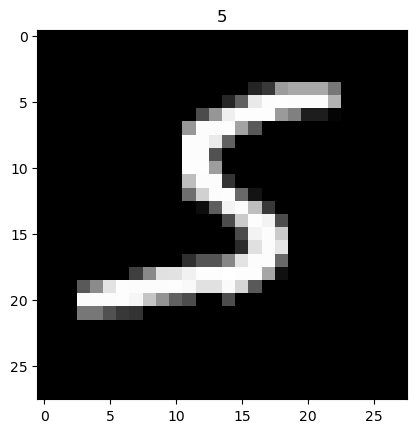

In [7]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')#image permute cahnce location paramaets for examle in  our case channer is 0 we permute and we write channel to 2 and so on

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [8]:
from torch.utils.data import DataLoader

In [9]:
bs = 64

trainloader=DataLoader(trainset, batch_size=bs, shuffle=True)
validloader=DataLoader(validset, batch_size=bs)
testloader=DataLoader(testset, batch_size=bs)

In [10]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [11]:
for images, labels in trainloader:
    print(f'One images batch shape: {images.shape}')
    print(f'One labels batch shape: {labels.shape}')
    break

One images batch shape: torch.Size([64, 1, 28, 28])
One labels batch shape: torch.Size([64])



# Load Model 

In [12]:
from models import DigitModel

model = DigitModel()
model.to('cpu')

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [13]:
def train_fn(model, dataloader, criterion, optimizer):
    
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    
    for images, labels in tqdm(dataloader):
       
        images= images.to('cpu')
        labels = labels.to('cpu')
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += utils.multiclass_accuracy(logits, labels)
    
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [14]:
def eval_fn(model, dataloader, criterion):
    
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):

            images= images.to('cpu')
            labels = labels.to('cpu')


            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += utils.multiclass_accuracy(logits, labels)

        return total_loss/len(dataloader), total_acc/len(dataloader)

# Training Loop 

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [16]:
best_valid_loss = np.Inf

for i in range(7):
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    
    print(f'Epoch {i+1} Train Loss : {train_loss} Train Acc : {train_acc}')
    print(f'Epoch {i+1} Valid Loss : {valid_loss} Valid Acc : {valid_acc}')
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        
    

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.788372944554557 Train Acc : 0.7267023921012878
Epoch 1 Valid Loss : 0.2604813953799665 Valid Acc : 0.923173725605011


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.40220471856462986 Train Acc : 0.8740209341049194
Epoch 2 Valid Loss : 0.18112241795234135 Valid Acc : 0.9483296275138855


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.31975594662187046 Train Acc : 0.9021539092063904
Epoch 3 Valid Loss : 0.1566181939304866 Valid Acc : 0.9546834826469421


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.28333817008415907 Train Acc : 0.9126838445663452
Epoch 4 Valid Loss : 0.14182880986958285 Valid Acc : 0.9579203724861145


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.2568657830872042 Train Acc : 0.9217551350593567
Epoch 5 Valid Loss : 0.12398231649042471 Valid Acc : 0.9642942547798157


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.2374266387365968 Train Acc : 0.9272698163986206
Epoch 6 Valid Loss : 0.1297887330934348 Valid Acc : 0.9629755616188049


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.22491314393156173 Train Acc : 0.9319453239440918
Epoch 7 Valid Loss : 0.11974920245730664 Valid Acc : 0.9660326242446899


# Inference

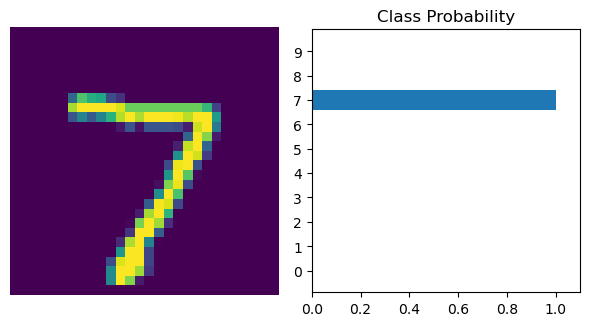

In [13]:
image, label = testset[0]

weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0)) #(c,h,w)->(1,c,h,w) in here we add 1 addininal column for batch size
    ps= torch.nn.Softmax(dim=1)(logits)[0]
    utils.view_classify(image,ps)

[[[201 197 196]
  [201 197 196]
  [202 198 197]
  ...
  [195 190 189]
  [202 197 196]
  [202 197 196]]

 [[202 198 197]
  [202 198 197]
  [202 198 197]
  ...
  [198 193 192]
  [200 195 194]
  [200 195 194]]

 [[202 198 197]
  [202 198 197]
  [202 198 197]
  ...
  [201 197 196]
  [196 192 191]
  [193 189 188]]

 ...

 [[207 198 195]
  [208 199 196]
  [209 199 199]
  ...
  [200 196 191]
  [200 196 191]
  [200 195 192]]

 [[205 195 195]
  [206 196 196]
  [209 199 199]
  ...
  [202 196 191]
  [202 196 191]
  [203 197 192]]

 [[209 199 199]
  [205 195 195]
  [203 193 193]
  ...
  [202 196 191]
  [202 196 191]
  [203 197 192]]]
tensor([6.5666e-11, 7.4050e-08, 6.2744e-07, 9.9975e-01, 2.2405e-10, 3.4345e-07,
        1.0276e-08, 2.5087e-04, 1.5611e-06, 6.7833e-07])


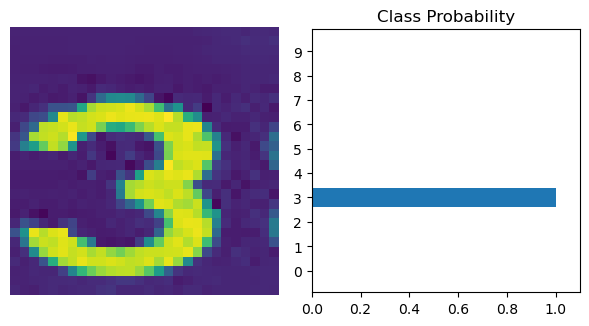

In [116]:
import cv2
from PIL import Image

model=DigitModel()
model.load_state_dict(torch.load('best_weights.pt'))


image_path = 'test_photo/p3.jpeg' 
test_img = cv2.imread(image_path)
print(test_img)
#img= test_img.astype(np.uint8)
test_img = 255 - test_img

img= cv2.resize(test_img.astype('uint8'),(28,28))
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #(28,28)->(28,28,1)
img= img[:,:,np.newaxis]/255.0

with torch.no_grad():
    img=torch.Tensor(img).permute(2,0,1)
    logits = model(img.unsqueeze(0)) 
    ps= torch.nn.Softmax(dim=1)(logits)[0]
   
    print(ps)
    utils.view_classify(img,ps)


In [ ]:
http://localhost:8888/view/Deep%20Learning/Tasks/pytorch/IMG_20231111_140131.jpg